In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def build_generator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)
    return Model(inputs, outputs)

def build_discriminator(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

def build_color_correction_model(generator, discriminator):
    inputs = tf.keras.Input(shape=input_shape)
    generated_images = generator(inputs)
    discriminator.trainable = False
    validity = discriminator(generated_images)
    return Model(inputs, [generated_images, validity])

def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def load_data(directory):
    images = []
    masks = []
    for file in os.listdir(directory):
        if file.endswith('_rgb.png'):
            image_path = os.path.join(directory, file)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error loading image: {image_path}")
                continue
            image = image / 255.0
            images.append(image)

            mask_file = file.replace('_rgb.png', '_fg.png')
            mask_path = os.path.join(directory, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error loading mask: {mask_path}")
                continue
            mask = mask / 255.0
            masks.append(mask)

    return np.array(images), np.array(masks)

def load_test_data(directory):
    images = []
    for file in os.listdir(directory):
        if file.endswith('.png'):
            image_path = os.path.join(directory, file)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error loading image: {image_path}")
                continue
            image = image / 255.0
            images.append(image)
    return np.array(images)

def apply_color_correction(image):
    image = (image * 255).astype(np.uint8)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_purple = np.array([120, 50, 50])
    upper_purple = np.array([150, 255, 255])
    mask = cv2.inRange(hsv, lower_purple, upper_purple)

    # Adjust the hue component
    hsv[:, :, 0] = (hsv[:, :, 0] + 90) % 180

    # Apply the mask to the saturation component
    hsv[:, :, 1] = np.where(mask[:, :] > 0, hsv[:, :, 1] * 0.5, hsv[:, :, 1])

    # Convert back to BGR color space
    corrected_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return corrected_image

def apply_color_correction_and_generate(generator_model, test_images):
    corrected_images = []
    generated_images = []

    for test_image in test_images:
        # Apply color correction to the test image
        corrected_image = apply_color_correction(test_image)
        corrected_images.append(corrected_image)

        # Reshape the corrected image to match the input shape of the generator
        corrected_image = corrected_image.reshape((1,) + corrected_image.shape)

        # Generate image using the color-corrected image
        generated_image = generator_model.predict(corrected_image)
        generated_images.append(generated_image[0])

    return corrected_images, generated_images

try:
    # Replace with your training and testing data directories
    train_data_directory = '/content/drive/MyDrive/DATASET (ALS-CLS)/CVPPP2017_LSC_training/CVPPP2017_LSC_training/training/A1'
    test_data_directory = '/content/drive/MyDrive/test purple'

    # Load training data
    train_images, train_masks = load_data(train_data_directory)

    # Set the input shape based on the first training image
    input_shape = train_images[0].shape

    # Build and train the generator
    generator = build_generator(input_shape)
    generator.compile(optimizer=optimizers.Adam(), loss=mse_loss)
    print("Generator training started...")
    generator.fit(train_images, train_images, batch_size=8, epochs=10)
    generator.save('color_correction_generator_model.h5')

    # Build and train the discriminator
    discriminator = build_discriminator(input_shape)
    discriminator.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Build and train the color correction model
    color_correction_model = build_color_correction_model(generator, discriminator)
    color_correction_model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    print("Color correction model training started...")
    color_correction_model.fit(train_images, [train_images, np.ones((len(train_images), 1))],
                           batch_size=8, epochs=1, steps_per_epoch=len(train_images) // 8)
    color_correction_model.save('color_correction_model.h5')

    # Load testing data
    test_images = load_test_data(test_data_directory)

    # Apply color correction to testing data and generate images
    corrected_test_images, generated_test_images = apply_color_correction_and_generate(generator, test_images)

    # Display or save the results as needed
    for i in range(len(test_images)):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i])
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(corrected_test_images[i])
        plt.title("Corrected Image")

        plt.subplot(1, 3, 3)
        plt.imshow(generated_test_images[i])
        plt.title("Generated Image")

        plt.show()

except Exception as e:
    print("Error:", e)


In [ ]:
separating the images

In [3]:
import os
import cv2

def separate_combined_images(input_directory, output_directory):
    try:
        # Create the output directories if they don't exist
        original_output_dir = os.path.join(output_directory, "original")
        corrected_output_dir = os.path.join(output_directory, "corrected")
        generated_output_dir = os.path.join(output_directory, "generated")

        for dir_path in [original_output_dir, corrected_output_dir, generated_output_dir]:
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

        # Loop through every image file in the input directory
        for filename in os.listdir(input_directory):
            if filename.endswith(".png") or filename.endswith(".jpg"):
                # Load the combined image
                combined_image_path = os.path.join(input_directory, filename)
                combined_image = cv2.imread(combined_image_path)

                if combined_image is None:
                    print(f"Failed to load the combined image: {combined_image_path}")
                    continue

                # Determine the width of each individual image (assuming all three images have the same width)
                width = combined_image.shape[1] // 3

                # Extract individual images from the combined image
                original_image = combined_image[:, :width]
                corrected_image = combined_image[:, width:2*width]
                generated_image = combined_image[:, 2*width:]

                # Save individual images to output directories
                cv2.imwrite(os.path.join(original_output_dir, filename), original_image)
                cv2.imwrite(os.path.join(corrected_output_dir, filename), corrected_image)
                cv2.imwrite(os.path.join(generated_output_dir, filename), generated_image)

                print(f"Separated images saved for {filename}.")

        print("Separation process completed.")
        return True

    except Exception as e:
        print(f"Error: {e}")
        return False

# Example usage
input_directory = '/content/drive/MyDrive/Generated_Images'  # Specify the directory containing combined images
output_directory = '/content/drive/MyDrive/Separated_Images'  # Specify the directory to save individual images

separate_combined_images(input_directory, output_directory)


Separated images saved for output_image_9.png.
Separated images saved for output_image_31.png.
Separated images saved for output_image_30.png.
Separated images saved for output_image_32.png.
Separated images saved for output_image_4.png.
Separated images saved for output_image_5.png.
Separated images saved for output_image_6.png.
Separated images saved for output_image_8.png.
Separated images saved for output_image_7.png.
Separation process completed.


True

In [ ]:
metrics

In [6]:
pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 882.1 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [8]:
import os
import cv2
import numpy as np
import lpips
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision.transforms as transforms

def calculate_metrics(original_image_path, corrected_image_path, generated_image_path):
    # Load the images
    original_image = cv2.imread(original_image_path)
    corrected_image = cv2.imread(corrected_image_path)
    generated_image = cv2.imread(generated_image_path)

    # Check if any image failed to load
    if original_image is None or corrected_image is None or generated_image is None:
        print("Error: Failed to load one or more images.")
        return None, None

    # Resize images to a common size (optional)
    min_height = min(original_image.shape[0], corrected_image.shape[0], generated_image.shape[0])
    min_width = min(original_image.shape[1], corrected_image.shape[1], generated_image.shape[1])

    original_image = cv2.resize(original_image, (min_width, min_height))
    corrected_image = cv2.resize(corrected_image, (min_width, min_height))
    generated_image = cv2.resize(generated_image, (min_width, min_height))

    # Convert images to grayscale for SSIM calculation (assuming images are RGB)
    original_image_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    generated_image_gray = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)

    # Calculate SSIM
    ssim_score = ssim(original_image_gray, generated_image_gray)

    # Calculate LPIPS
    lpips_score = calculate_lpips(original_image, generated_image)

    return ssim_score, lpips_score

def calculate_lpips(original_image, generated_image):
    # Ensure images are in float32 format and normalized to [0, 1]
    original_image = original_image.astype(np.float32) / 255.0
    generated_image = generated_image.astype(np.float32) / 255.0

    # Convert NumPy arrays to PyTorch tensors
    transform = transforms.ToTensor()
    original_image_tensor = transform(original_image).unsqueeze(0)  # Add batch dimension
    generated_image_tensor = transform(generated_image).unsqueeze(0)  # Add batch dimension

    # Initialize LPIPS model
    lpips_model = lpips.LPIPS(net='alex')

    # Compute LPIPS score
    lpips_score = lpips_model(original_image_tensor, generated_image_tensor)

    return lpips_score.item()

# Example usage
original_image_path = '/content/drive/MyDrive/Separated_Images/original/output_image_30.png'
corrected_image_path = '/content/drive/MyDrive/Separated_Images/corrected/output_image_30.png'
generated_image_path = '/content/drive/MyDrive/Separated_Images/generated/output_image_30.png'

ssim_score, lpips_score = calculate_metrics(original_image_path, corrected_image_path, generated_image_path)

if ssim_score is not None and lpips_score is not None:
    print(f"SSIM: {ssim_score:.2f}, LPIPS: {lpips_score:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 79.2MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
SSIM: 0.67, LPIPS: 0.5808


In [ ]:
training unet model(unsupervised)

# New Section

In [ ]:
import os
import cv2
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set your data directory
data_directory = '/content/drive/MyDrive/DATASET (ALS-CLS)/CVPPP2017_LSC_training/CVPPP2017_LSC_training/training/A1'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(data_directory) if f.endswith('_rgb.png')]

# Sort the files to ensure images and masks are in the same order
image_files.sort()

# Load and preprocess images and masks
X_train = []
y_train = []

for image_file in image_files:
    # Load and preprocess images
    image_path = os.path.join(data_directory, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))  # Resize for consistency
    image = image / 255.0  # Normalize pixel values to [0, 1]
    # Apply any other preprocessing steps as needed
    # ...

    # Load and preprocess masks
    mask_file = re.sub('_rgb.png', '_fg.png', image_file)  # Assuming masks end with '_fg.png'
    mask_path = os.path.join(data_directory, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))  # Resize for consistency
    mask = mask / 255.0  # Normalize pixel values to [0, 1]
    # Apply any other preprocessing steps as needed
    # ...

    X_train.append(image)
    y_train.append(mask)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define U-Net model
def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    concat4 = concatenate([conv2, up4], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    concat5 = concatenate([conv1, up5], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model

# Compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
1/4 [======>.......................] - ETA: 7:01 - loss: 0.6903 - accuracy: 0.8264

In [ ]:
saving model

In [ ]:
# Save the entire model
model.save('unet_segmentation_model.h5')

# Load the saved model
loaded_model = tf.keras.models.load_model('unet_segmentation_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
testing model

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the saved model
loaded_model = tf.keras.models.load_model('unet_segmentation_model.h5')

# Path to the directory containing test images and masks
test_data_directory = '/content/drive/MyDrive/A1'

# Get a list of all test image files in the directory
test_image_files = [f for f in os.listdir(test_data_directory) if f.endswith('_rgb.png')]

# Process each test image
all_true_masks = []
all_pred_masks = []

for test_image_file in test_image_files:
    # Load the test image
    test_image_path = os.path.join(test_data_directory, test_image_file)
    test_image = cv2.imread(test_image_path)
    test_image = cv2.resize(test_image, (256, 256))  # Resize for consistency
    test_image = test_image / 255.0  # Normalize pixel values to [0, 1]

    # Make predictions on the test image
    predictions = loaded_model.predict(np.expand_dims(test_image, axis=0))

    # Load the true mask
    true_mask_file = test_image_file.replace('_rgb.png', '_fg.png')
    true_mask_path = os.path.join(test_data_directory, true_mask_file)
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.resize(true_mask, (256, 256))  # Resize for consistency
    true_mask = true_mask / 255.0  # Normalize pixel values to [0, 1]

    # Example post-processing (thresholding)
    threshold = 0.5  # Adjust as needed
    pred_mask = (predictions > threshold).astype(np.uint8).squeeze()

    # Save the true and predicted masks for later evaluation
    all_true_masks.append(true_mask)
    all_pred_masks.append(pred_mask)

    # Visualize the results
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(test_image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')  # Display the predicted mask
    plt.title('Predicted Mask')

    plt.show()



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
a*b* to corrected image us

In [ ]:
import cv2
import numpy as np
def rgb_to_lab(rgb_image):
    lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LAB)
    return lab_image
def combine_lab_channels(L, ab_combined):
    lab_image = np.zeros((L.shape[0], L.shape[1], 3))
    lab_image[:, :, 0] = L  # L* channel
    lab_image[:, :, 1:] = ab_combined  # a* and b* channels
    return lab_image
def lab_to_rgb(lab_image):
    rgb_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
    return rgb_image
rgb_image = cv2.imread('/content/drive/MyDrive/A1/plant003_rgb.png')
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
# Replace 'ab_combined_image.jpg' with the path to your a*b* combined image file
ab_combined_image = cv2.imread('content/drive/MyDrive/arshi/combined_ab_image.jpg', cv2.IMREAD_COLOR)
a_channel, b_channel = cv2.split(ab_combined_image)
L_channel = rgb_to_lab(rgb_image)[:, :, 0]
lab_image = combine_lab_channels(L_channel, np.stack((a_channel, b_channel), axis=-1))
corrected_image = lab_to_rgb(lab_image)
cv2.imwrite('content/drive/MyDrive/arshi/corrected1.jpg', corrected_image)


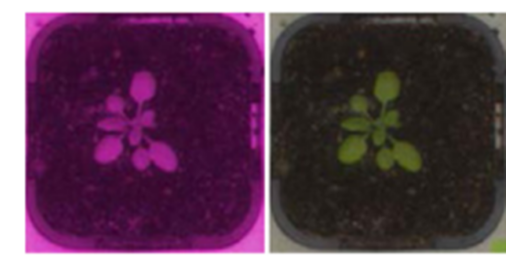

In [ ]:
'output

In [ ]:
PART2

100%|██████████| 300/300 [04:23<00:00,  1.14it/s]


Image shape: (530, 500, 3)
Labels shape: (265, 250)
Label: 0 Mask shape: (265, 250)
Label: 1 Mask shape: (265, 250)
Label: 2 Mask shape: (265, 250)
Label: 3 Mask shape: (265, 250)
Label: 4 Mask shape: (265, 250)
Label: 5 Mask shape: (265, 250)
Label: 6 Mask shape: (265, 250)
Label: 7 Mask shape: (265, 250)
Label: 8 Mask shape: (265, 250)
Label: 9 Mask shape: (265, 250)
Label: 10 Mask shape: (265, 250)
Label: 11 Mask shape: (265, 250)
Label: 12 Mask shape: (265, 250)
Label: 13 Mask shape: (265, 250)
Label: 14 Mask shape: (265, 250)
Label: 15 Mask shape: (265, 250)
Label: 16 Mask shape: (265, 250)
Label: 17 Mask shape: (265, 250)
Label: 18 Mask shape: (265, 250)
Label: 19 Mask shape: (265, 250)
Label: 20 Mask shape: (265, 250)
Label: 21 Mask shape: (265, 250)
Label: 22 Mask shape: (265, 250)
Label: 23 Mask shape: (265, 250)
Label: 24 Mask shape: (265, 250)
Label: 25 Mask shape: (265, 250)
Label: 26 Mask shape: (265, 250)
Label: 27 Mask shape: (265, 250)
Label: 28 Mask shape: (265, 250)
L

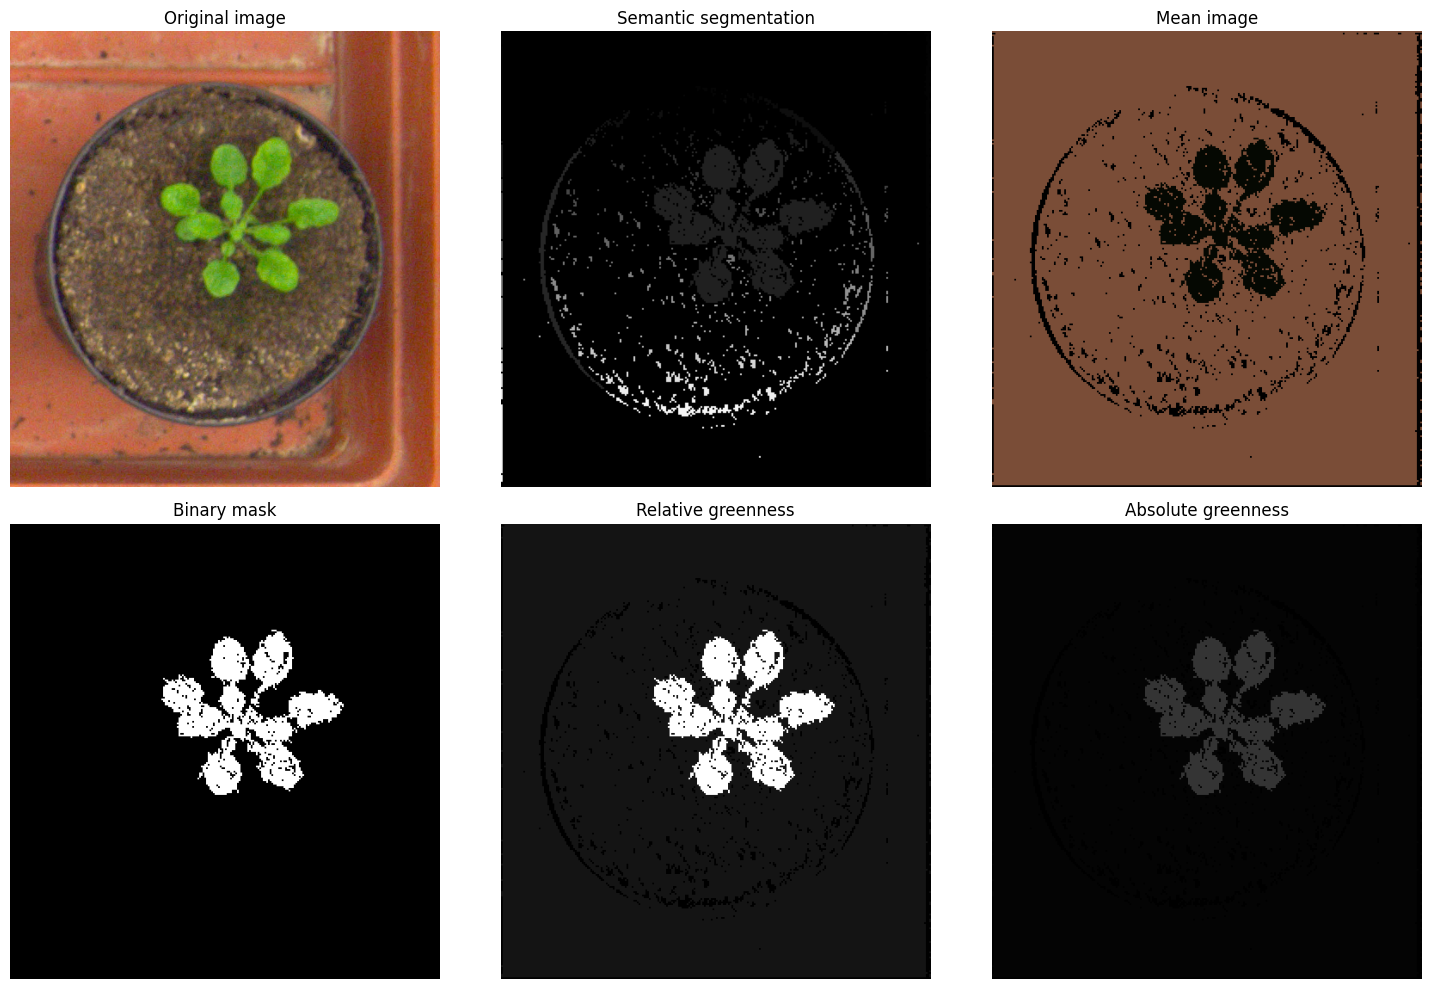

Result has been saved in /content/drive/MyDrive/output/result/result.jpg


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from tqdm import tqdm

import torch.nn as nn
from torch.autograd import Variable
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Softmax2d()
        )

    def forward(self, x):
        # Encoder
        x1 = self.encoder(x)

        # Decoder
        out = self.decoder(x1)

        return out

import cv2

def mean_image(image_path, labels):
    # Load image data
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print("Image shape:", image.shape)
    print("Labels shape:", labels.shape)

    mean_img = np.zeros_like(image)

    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = labels == label
        print("Label:", label, "Mask shape:", mask.shape)
        if np.any(mask):
            # Resize the mask to match the dimensions of the image
            mask_resized = cv2.resize(mask.astype(np.uint8), (image.shape[1], image.shape[0]))
            masked_image = image.copy()
            masked_image[mask_resized == 0] = 0  # Apply mask
            mean_rgb = np.mean(masked_image, axis=(0, 1))
            mean_img[mask_resized == 1] = mean_rgb.astype('uint8')
    return mean_img

def cal_greenness(rgb_image):
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV).astype(np.float64)
    hsv[..., 0] /= 180.0
    hsv[..., 1:] /= 255.0

    mu = np.array([60.0 / 180.0, 160.0 / 255.0, 200.0 / 255.0])
    sigma = np.array([.1, .3, .5])
    covariance = np.diag(sigma ** 2)

    rv = multivariate_normal(mean=mu, cov=covariance)
    z = rv.pdf(hsv)
    ref = rv.pdf(mu)
    absolute_greenness = z / ref
    relative_greenness = (z - np.min(z)) / (np.max(z) - np.min(z) + np.finfo(float).eps)
    return absolute_greenness, relative_greenness

def save_result_img(save_path, rgb_img, labels, mean_img, absolute_greenness, relative_greenness, thresholded):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    axes[0, 0].imshow(rgb_img)
    axes[0, 0].set_title('Original image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(labels, cmap='gray')  # Convert to grayscale for visualization
    axes[0, 1].set_title('Semantic segmentation')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(mean_img)
    axes[0, 2].set_title('Mean image')
    axes[0, 2].axis('off')

    axes[1, 0].imshow(thresholded, cmap='gray')
    axes[1, 0].set_title('Binary mask')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(relative_greenness, cmap='gray', vmin=0, vmax=1)
    axes[1, 1].set_title('Relative greenness')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(absolute_greenness, cmap='gray', vmin=0, vmax=1)
    axes[1, 2].set_title('Absolute greenness')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def parse_args():
    class Args:
        def __init__(self):
            self.max_iter = 300
            self.min_labels = 2
            self.lr = 0.1
            self.sz_filter = 5
            self.at = 0.2
            self.rt = 0.5
            self.save_video = False
            self.save_frame_interval = 2
            self.save_path = "/content/drive/MyDrive/output/result"  # Save to Google Drive
            self.input = "content/drive/MyDrive/arshi/correctedfinal.jpg"

    return Args()

if __name__ == "__main__":
    args = parse_args()
    if not os.path.exists(args.save_path):
        os.makedirs(args.save_path)

    # Load image
    img = cv2.imread(args.input)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = img.shape[:2]
    img = img.transpose(2, 0, 1)
    img_var = torch.Tensor(img.reshape([1, 3, *img_size]))

    # Create backbone model
    model = UNet(in_channels=3, out_channels=2)

    # Process image and perform segmentation
    for batch_idx in tqdm(range(args.max_iter)):
        output = model(img_var)

        # Convert output to numpy array and perform argmax to get labels
        segmentation_result = output.argmax(dim=1).squeeze().cpu().numpy()

        # Label connected components to count number of labels
        num_labels = len(np.unique(measure.label(segmentation_result)))

        # Check stopping condition
        if num_labels <= args.min_labels:
            break

        # You can perform additional processing on segmentation_result if needed

    # Perform post-processing and visualization
    rgb_image = cv2.imread(args.input)
    rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
    labels = measure.label(segmentation_result)
    mean_img = mean_image(args.input, labels)

    absolute_greenness, relative_greenness = cal_greenness(mean_img)
    greenness = np.multiply(relative_greenness, (absolute_greenness > args.at).astype(np.float64))
    thresholded = 255 * ((greenness > args.rt).astype("uint8"))
    save_result_img(args.save_path, rgb_image, labels, mean_img,
                    absolute_greenness, relative_greenness, thresholded)

save_result_path = os.path.join(args.save_path, "result.jpg")
print('Result has been saved in {}'.format(save_result_path))


In [ ]:
FBD CALCULATION

In [ ]:
import cv2

def calculate_fbd(true_mask_path, predicted_mask_path):
    # Load the true and predicted masks
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

    # Binarize the masks (if not already binary)
    true_mask = (true_mask > 0).astype(np.uint8)
    predicted_mask = (predicted_mask > 0).astype(np.uint8)

    # Compute the intersection of the masks
    intersection = np.logical_and(true_mask, predicted_mask)

    # Calculate true positives (TP), false positives (FP), and false negatives (FN)
    tp = np.sum(intersection)
    fp = np.sum(predicted_mask) - tp
    fn = np.sum(true_mask) - tp

    # Calculate the FBD score
    fbd = 2 * tp / (2 * tp + fp + fn)
    return fbd
true_mask_path = "/content/drive/MyDrive/IndividualImages/true_mask.jpg"
predicted_mask_path = "/content/drive/MyDrive/IndividualImages/predicted_mask.jpg"

fbd_score = calculate_fbd(true_mask_path, predicted_mask_path)
print("FBD score:", fbd_score*100)


FBD score: 89.79228121927237
